In [1]:
import os
os.chdir('E:\Jupyterspace')

In [23]:
import pandas as pd
data = pd.read_excel('pmcopd.xlsx')
data.head()

,date,event,holiday,week,so2,no2,co,o3,pm25,pm10,temp,rh
0,2013-01-01,214,1,2,NaN,NaN,NaN,NaN,NaN,NaN,-7,36
1,2013-01-02,141,1,3,NaN,NaN,NaN,NaN,NaN,NaN,-10,23
2,2013-01-03,110,1,4,NaN,NaN,NaN,NaN,NaN,NaN,-9,30
3,2013-01-04,206,0,5,NaN,NaN,NaN,NaN,NaN,NaN,-10,44
4,2013-01-05,186,0,6,NaN,NaN,NaN,NaN,NaN,NaN,-7,36


## 1、缺失情况

### 1.1 统计各个变量缺失值个数

In [24]:

data.isnull().sum()


date        0
event       0
holiday     0
week        0
so2        22
no2        22
co         22
o3         56
pm25       22
pm10       27
temp        0
rh          0
dtype: int64

### 1.2 统计非缺失个数

In [18]:

data.count()


event      1826
holiday    1826
week       1826
so2        1804
no2        1804
co         1804
o3         1770
pm25       1804
pm10       1799
temp       1826
rh         1826
dtype: int64

### 1.3 设置索引
因为日期date没有缺失值，因此可以直接设置为索引

In [25]:
data = data.set_index('date') # 将日期设置为索引，务必保证没有缺失值
data.head()

,event,holiday,week,so2,no2,co,o3,pm25,pm10,temp,rh
date,,,,,,,,,,,
2013-01-01,214,1,2,NaN,NaN,NaN,NaN,NaN,NaN,-7,36
2013-01-02,141,1,3,NaN,NaN,NaN,NaN,NaN,NaN,-10,23
2013-01-03,110,1,4,NaN,NaN,NaN,NaN,NaN,NaN,-9,30
2013-01-04,206,0,5,NaN,NaN,NaN,NaN,NaN,NaN,-10,44
2013-01-05,186,0,6,NaN,NaN,NaN,NaN,NaN,NaN,-7,36


### 1.4 统计缺失值数量和比例

定义函数来实现

- 统计每个变量的数据量 data.count() 
- 统计数据行数 len(data)
- 二者差值为缺失值数量
- 拼接数量与比例 pd.concat()

In [17]:
def na_count(data):
    data_count = data.count()              
    na_count = len(data) - data_count            
    na_rate = na_count/len(data)               
    result = pd.concat([data_count,na_count,na_rate],axis = 1)   
    return result
na_count(data)

,0,1,2
event,1826,0,0.000000
holiday,1826,0,0.000000
week,1826,0,0.000000
so2,1804,22,0.012048
no2,1804,22,0.012048
co,1804,22,0.012048
o3,1770,56,0.030668
pm25,1804,22,0.012048
pm10,1799,27,0.014786
temp,1826,0,0.000000


### 1.5 统计查看有缺失值的行

In [96]:

nan_data = data[data.isnull().values==True].drop_duplicates()

print("缺失记录共有 %s 行 " % (nan_data.shape[0]))

nan_data.head()


缺失记录共有 61 行 


## 2、缺失值处理

缺失比例过大，可直接删除变量

缺失比例很小，小于5%，可直接删除记录

其他情况，根据业务实际进行多种方法填充：固定值填充（均值、中位数、分组后、邻近值）、插值、最近邻、随机森林、多重插补（回归）


### 2.1 直接删除缺失记录 dropna

axis=0 代表行，axis=1 代表列，thresh = 4‘删除值少于4个数的值’，subset = ['C'] 删除’c‘列中有缺失值的行数据

In [19]:
data_nan = data.dropna(axis = 0) 
na_count(data_nan)

,0,1,2
event,1765,0,0.0
holiday,1765,0,0.0
week,1765,0,0.0
so2,1765,0,0.0
no2,1765,0,0.0
co,1765,0,0.0
o3,1765,0,0.0
pm25,1765,0,0.0
pm10,1765,0,0.0
temp,1765,0,0.0


###  2.2 固定值填充方法一： sklearn.preprocessing.Imputer

sklearn.preprocessing.Imputer(missing_values=’NaN’, strategy=’mean’, axis=0, verbose=0, copy=True)

主要参数说明：

missing_values：指定缺失值，可以为整数或NaN(缺失值numpy.nan用字符串‘NaN’表示)，默认为NaN

strategy：替换策略，字符串，默认用均值‘mean’替换

    ①若为mean时，用特征列的均值替换

    ②若为median时，用特征列的中位数替换

    ③若为most_frequent时，用特征列的众数替换

axis：指定轴数，默认axis=0代表列，axis=1代表行

copy：设置为True代表不在原数据集上修改，设置为False时，就地修改，存在如下情况时，即使设置为False时，也不会就地修改

    ①X不是浮点值数组

    ②X是稀疏且missing_values=0

    ③axis=0且X为CRS矩阵

    ④axis=1且X为CSC矩阵

statistics_属性：axis设置为0时，每个特征的填充值数组，axis=1时，报没有该属性错误

#### 注意：填充后数据需要进行类型转化pd.DataFrame


In [30]:
from sklearn.preprocessing import Imputer
nan_model = Imputer(missing_values='NaN', strategy='median',axis=0) 
nan_imputer = nan_model.fit_transform(data) 
data_imputer = pd.DataFrame(nan_imputer,columns=data.columns,index = data.index) 
data_imputer.head()

,event,holiday,week,so2,no2,co,o3,pm25,pm10,temp,rh
date,,,,,,,,,,,
2013-01-01,214.0,1.0,2.0,8.0,44.0,0.9335,83.0,58.0,89.0,-7.0,36.0
2013-01-02,141.0,1.0,3.0,8.0,44.0,0.9335,83.0,58.0,89.0,-10.0,23.0
2013-01-03,110.0,1.0,4.0,8.0,44.0,0.9335,83.0,58.0,89.0,-9.0,30.0
2013-01-04,206.0,0.0,5.0,8.0,44.0,0.9335,83.0,58.0,89.0,-10.0,44.0
2013-01-05,186.0,0.0,6.0,8.0,44.0,0.9335,83.0,58.0,89.0,-7.0,36.0


### 2.3、固定值填充方法二： pandas.fillna

DataFrame.fillna(value=None, method=None, axis=None, inplace=False, limit=None, downcast=None)

    value：表示传入的定值。可为某一个值，dict,Series,DataFrame。无默认

    method：此参数存在，则不传入value。表示使用前一个非空值(method = 'ffill')或后一个非空值(method='bfill')进行缺失值填补。无默认。若从往前全部数据为空，或往后全部数据为空则无法填充

    axis：表示轴向。

    inplace：表示是否对原数据进行操作。默认为False，不对原数据操作。

    limit：表示插补多少次。默认全量插补。

####  注意：当众数不唯一时无法填充

选择第一个众数

df.fillna(df.mode()[0], inplace=True)

#### tips：可以用字典为不同列指定不同值进行填充

values={0:10,1:20,2:30}

data.fillna(value=values)



In [14]:
data_fill_zero = data.fillna(0)
data_fill_mean = data.fillna(data.mean())
data_fill_bfill = data.fillna(method='bfill') 

### 分组均值填充方法一、fillna 更简洁
1、按照industryName1列，筛选出业绩

2、筛选出相同行业的Series

3、计算平均值mean，采用fillna函数填充

4、append到新DataFrame中

5、循环遍历行业名称，完成2,3,4步骤



In [33]:
# 用于存放填充后数据
data_fill_group_1 = pd.DataFrame()
# 统计分组枚举值
industrys = data.holiday.unique()

for ind in industrys:

    t = data.holiday == ind

    a = data[t].fillna(data[t].median())

    data_fill_group_1 = data_fill_group_1.append(a)
    
data_fill_group_1.head()

,event,holiday,week,so2,no2,co,o3,pm25,pm10,temp,rh
date,,,,,,,,,,,
2013-01-01,214,1,2,8.0,44.0,0.964,86.5,60.0,90.0,-7,36
2013-01-02,141,1,3,8.0,44.0,0.964,86.5,60.0,90.0,-10,23
2013-01-03,110,1,4,8.0,44.0,0.964,86.5,60.0,90.0,-9,30
2013-01-12,95,1,6,8.0,44.0,0.964,86.5,60.0,90.0,-7,81
2013-01-13,85,1,7,8.0,44.0,0.964,86.5,60.0,90.0,-4,79


### 分组均值填充方法二、group 
1、统计分组结果

2、判断每个位置是否有缺失值，返回一个T/F矩阵

3、记录缺失值索引

4、根据索引和分组结果，将缺失值填充到指定位置

提取填充过程中需要用到的列，按列名提取

In [4]:
# cols = [col for col in data.columns if col not in['event','week']]
cols = data.columns

In [6]:
# 设置分组变量
gp_col = 'holiday'
# 统计分组结果
df_mean = data.groupby(gp_col)[cols].mean()
# 是否缺失
df_na = data[cols].isna()

In [7]:
# 依次处理每一列
data_fill_group_2 = data
for col in cols:
    # 提取需要填充缺失值的一列
    na_series = df_na[col]
    
    # 取出该列缺失值位置对应的分组变量值
    names = list(data_fill_group_2.loc[na_series,gp_col])
    
    # 根据缺失值对应分组值，分别进行填充
    t = df_mean.loc[names,col]
    
    # 缺失值索引
    t.index = data_fill_group_2.loc[na_series,col].index
    
    # 相同的index进行赋值
    data_fill_group_2.loc[na_series,col] = t
    
data_fill_group_2.head()

,event,holiday,week,so2,no2,co,o3,pm25,pm10,temp,rh
date,,,,,,,,,,,
2013-01-01,214.0,1.0,2.0,15.897033,50.280977,1.254054,97.762500,80.509599,111.670157,-7.0,36.0
2013-01-02,141.0,1.0,3.0,15.897033,50.280977,1.254054,97.762500,80.509599,111.670157,-10.0,23.0
2013-01-03,110.0,1.0,4.0,15.897033,50.280977,1.254054,97.762500,80.509599,111.670157,-9.0,30.0
2013-01-04,206.0,0.0,5.0,14.784728,50.588952,1.210632,94.876033,74.887896,103.821370,-10.0,44.0
2013-01-05,186.0,0.0,6.0,14.784728,50.588952,1.210632,94.876033,74.887896,103.821370,-7.0,36.0


### 插值法 interpolate 

通过多个点（x0，y0），（x1，y1）估计中间点的值

定义函数  x:横坐标列表 y:纵坐标列表 

插值方式kind： slinear、linear：线性插值 |nearest：最邻近插值法 |quadratic、cubic：2、3阶B样条曲线插值 |zero：阶梯插值

In [17]:

import numpy as np

from scipy.interpolate import interp1d

x=np.linspace(0,10*np.pi,num=20)

y=np.sin(x)

f1=interp1d(x,y,kind='linear')#线性插值

f2=interp1d(x,y,kind='cubic')#三次样条插值

x_pred=np.linspace(0,10*np.pi,num=1000)

y1=f1(x_pred)

y2=f2(x_pred)

In [69]:
test = data
test['so2'] = test['so2'].interpolate()
test.head(20)

,event,holiday,week,so2,no2,co,o3,pm25,pm10,temp,rh
date,,,,,,,,,,,
2013-01-01,214,1,2,NaN,NaN,NaN,NaN,NaN,NaN,-7,36
2013-01-02,141,1,3,NaN,NaN,NaN,NaN,NaN,NaN,-10,23
2013-01-03,110,1,4,NaN,NaN,NaN,NaN,NaN,NaN,-9,30
2013-01-04,206,0,5,NaN,NaN,NaN,NaN,NaN,NaN,-10,44
2013-01-05,186,0,6,NaN,NaN,NaN,NaN,NaN,NaN,-7,36
2013-01-06,163,0,7,NaN,NaN,NaN,NaN,NaN,NaN,-7,43
2013-01-07,192,0,1,NaN,NaN,NaN,NaN,NaN,NaN,-7,54
2013-01-08,203,0,2,NaN,NaN,NaN,NaN,NaN,NaN,-7,45
2013-01-09,170,0,3,NaN,NaN,NaN,NaN,NaN,NaN,-7,39


In [ ]:
na_count(data)

In [16]:
nan_fill.isnull().sum()

date       0
event      0
holiday    0
week       0
so2        0
no2        0
co         0
o3         0
pm25       0
pm10       0
temp       0
rh         0
dtype: int64

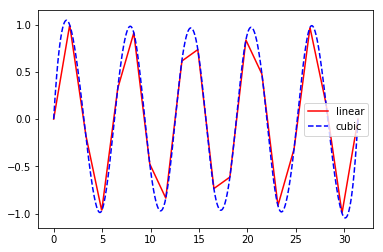

In [19]:
from matplotlib import pyplot as plt
plt.plot(x_pred,y1,'r',label='linear')
plt.plot(x_pred,y2,'b--',label='cubic')
plt.legend()
plt.show()

In [88]:

def nan_index(data):
    nan_index =  pd.DataFrame()
    for col in data.columns:
        na_series = df_na[col] # 缺失矩阵T/F
        a = data.loc[na_series].index
        a = pd.DataFrame(a)
        nan_index = nan_index.append(a)
        nan_index = nan_index.drop_duplicates()
    nan_data = data.loc[nan_index['date']]
    return nan_data

nan_index(data)    

In [21]:
data2 = data
num = data2['so2'][data2['so2'].notnull()]  # 不为空的数据

In [32]:
yp = data2['so2'].interpolate(limit_direction='both', kind='nearest')

In [33]:
data2['so2'].head(20)

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7      NaN
8      NaN
9      NaN
10     NaN
11     NaN
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17    91.0
18    83.0
19    35.0
Name: so2, dtype: float64

In [34]:
yp.head(20)

0     91.0
1     91.0
2     91.0
3     91.0
4     91.0
5     91.0
6     91.0
7     91.0
8     91.0
9     91.0
10    91.0
11    91.0
12    91.0
13    91.0
14    91.0
15    91.0
16    91.0
17    91.0
18    83.0
19    35.0
Name: so2, dtype: float64

In [36]:
# 拉格朗日插值
import pandas as pd 
from scipy.interpolate import lagrange   


def ployinterp_column(s,n,k=5):
    y = s[list(range(n-k,n)) + list(range(n+1,n+1+k))] 
    y = y[y.notnull()] 
    return lagrange(y.index,list(y))(n)


In [37]:
for i in data2.columns:
    for j in range(len(data2)):
        if (data2[i].isnull())[j]:  
            data2[i][j] = ployinterp_column(data2[i],j)


D:\Anaconda3\lib\site-packages\pandas\core\series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [38]:
na_count(data2)

,0,1,2
date,1826,0,0.0
event,1826,0,0.0
holiday,1826,0,0.0
week,1826,0,0.0
so2,1826,0,0.0
no2,1826,0,0.0
co,1826,0,0.0
o3,1826,0,0.0
pm25,1826,0,0.0
pm10,1826,0,0.0


In [40]:
data2.head(20)

,date,event,holiday,week,so2,no2,co,o3,pm25,pm10,temp,rh
0,2013-01-01,214,1,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7,36
1,2013-01-02,141,1,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10,23
2,2013-01-03,110,1,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9,30
3,2013-01-04,206,0,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10,44
4,2013-01-05,186,0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7,36
5,2013-01-06,163,0,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7,43
6,2013-01-07,192,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7,54
7,2013-01-08,203,0,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7,45
8,2013-01-09,170,0,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7,39
9,2013-01-10,195,0,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9,69


In [ ]:
# KNN
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute
data = KNN(k=3).complete(data)

In [28]:
import numpy as np 
test1=np.array([1,2,'aa',3]) 
list1=list(test1) 

def filter_fun(x): 
    try: 
        return isinstance(float(x),(float)) 
    except: 
        return False





In [ ]:
np.array(filter(filter_fun,list1)) 

np.array(list(filter(filter_fun,list1))) 

np.array([float(x) for x in filter(filter_fun,list1)]) 

In [27]:
# data[data.isnull().values==True]

# for columname in data.columns:
#     if data[columname].count() != len(data):
#          loc = data[columname][data[columname].isnull().values==True].index.tolist()
#          print('列名："{}", 第{}行位置有缺失值'.format(columname,loc))


# data[data['o3'].isnull()|data['pm25'].isnull()]
# import numpy as np
# np.isnan(data[,1:-1])
data.str.isnumeric()


AttributeError: 'DataFrame' object has no attribute 'str'